In [1]:
import jax
print("JAX path:", jax.__file__)

JAX path: /Users/yuxin/miniconda3/lib/python3.12/site-packages/jax/__init__.py


In [2]:
## load module
import bstpp
import numpy as np
import numpyro.distributions as dist
import pandas as pd
import geopandas as gpd
from datetime import timedelta
import matplotlib.pyplot as plt
np.random.seed(999)

/Users/yuxin/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
from bstpp.main import LGCP_Model, Hawkes_Model, load_Chicago_Shootings, load_Boko_Haram

In [3]:
## set working directory
import os
os.chdir("/Users/yuxin/Dropbox/DDDI/Illegal-Dumping")

In [4]:
## load data
litter_24 = gpd.read_file('data/311/2024/public_cases_fc.shp')

## filter data
illegal_dumping_24 = litter_24[litter_24['service_na'] == "Illegal Dumping"]

In [5]:
## prepare boundry of philly like "boundry"

# load shapefile of PA in 2024 from ACS
PA = gpd.read_file('data/tl_2024_42_bg/tl_2024_42_bg.shp')

# restrict to philly
philly = PA[PA['COUNTYFP'] == "101"]

# add a small buffer to the boundaries
philly_buffered = philly.buffer(0.01)  # Add 0.01 degrees buffer

/var/folders/nr/q7sysy9j07x_5smd2gfx3j380000gn/T/ipykernel_22159/4138501801.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  philly_buffered = philly.buffer(0.01)  # Add 0.01 degrees buffer


In [7]:
# filter points in philly
illegal_dumping_24 = illegal_dumping_24.sjoin(philly, predicate='within')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/geopandas/geodataframe.py:2391: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:4269

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)  # noqa: B026


In [8]:
## prepare locs and t as "events_2022" from the sample data

# jitter the time
illegal_dumping_24['jittered_time'] = illegal_dumping_24['requested_'] + \
    pd.to_timedelta(np.random.uniform(0, 86400, len(illegal_dumping_24)), unit='s')

# get coordinates from the geometry
coords = pd.DataFrame({
    'x': illegal_dumping_24.geometry.centroid.x,
    'y': illegal_dumping_24.geometry.centroid.y
})

# calculate time difference in days from the minimum date
min_time = illegal_dumping_24['jittered_time'].min()
time_diff = (illegal_dumping_24['jittered_time'] - min_time).dt.total_seconds() / (24 * 60 * 60)
illegal_dumping_24['time_diff'] = (illegal_dumping_24['jittered_time'] - min_time).dt.total_seconds() / (24 * 60 * 60)

locs_s = pd.DataFrame({'X': coords['x'], 'Y': coords['y'], 'T': time_diff})

# Reset index and ensure proper column names
locs_s = locs_s.reset_index(drop=True)

# Make sure columns are properly named and data types are correct
locs_s = pd.DataFrame({'X': coords['x'], 'Y': coords['y'], 'T': time_diff})
locs_s = locs_s.astype({'X': float, 'Y': float, 'T': float})

/var/folders/nr/q7sysy9j07x_5smd2gfx3j380000gn/T/ipykernel_32202/2698708978.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  'x': illegal_dumping_24.geometry.centroid.x,
/var/folders/nr/q7sysy9j07x_5smd2gfx3j380000gn/T/ipykernel_32202/2698708978.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  'y': illegal_dumping_24.geometry.centroid.y


In [10]:
## sample locs_s data
# First, let's create time bins to ensure even distribution
n_samples = 3000
n_bins = 20  # You can adjust this number

# Create time bins and assign them to the data
locs_s['time_bin'] = pd.qcut(locs_s['T'], q=n_bins, labels=False)

# Stratified sampling from each bin
samples_per_bin = n_samples // n_bins
sampled_locs = pd.DataFrame()
for bin_id in range(n_bins):
    bin_data = locs_s[locs_s['time_bin'] == bin_id]
    sampled_bin = bin_data.sample(n=min(samples_per_bin, len(bin_data)))
    sampled_locs = pd.concat([sampled_locs, sampled_bin])

# If we need exactly 2000 points (in case of rounding)
if len(sampled_locs) < n_samples:
    remaining = n_samples - len(sampled_locs)
    additional = locs_s[~locs_s.index.isin(sampled_locs.index)].sample(n=remaining)
    sampled_locs = pd.concat([sampled_locs, additional])

# Drop the time_bin column as we don't need it anymore
sampled_locs = sampled_locs.drop('time_bin', axis=1)

# Sort by time
sampled_locs = sampled_locs.sort_values('T')

# Reset index and drop it
sampled_locs = sampled_locs.reset_index(drop=True)

In [11]:
# sample locs_s data for half a year
n_samples = 3000
n_bins = 20  # You can adjust this number

# Filter locs_s to only first 180 days
locs_s_halfyear = locs_s[locs_s['T'] <= 60]

# Create time bins and assign them to the filtered data
locs_s_halfyear['time_bin'] = pd.qcut(locs_s_halfyear['T'], q=n_bins, labels=False)

# Stratified sampling from each bin
samples_per_bin = n_samples // n_bins
sampled_locs = pd.DataFrame()
for bin_id in range(n_bins):
    bin_data = locs_s_halfyear[locs_s_halfyear['time_bin'] == bin_id]
    sampled_bin = bin_data.sample(n=min(samples_per_bin, len(bin_data)))
    sampled_locs = pd.concat([sampled_locs, sampled_bin])

# If we need exactly 3000 points (in case of rounding)
#if len(sampled_locs) < n_samples:
#    remaining = n_samples - len(sampled_locs)
#    additional = locs_s_halfyear[~locs_s_halfyear.index.isin(sampled_locs.index)].sample(n=remaining)
#    sampled_locs = pd.concat([sampled_locs, additional])

# Drop the time_bin column as we don't need it anymore
sampled_locs = sampled_locs.drop('time_bin', axis=1)

# Sort by time
sampled_locs = sampled_locs.sort_values('T')

# Reset index and drop old index
sampled_locs = sampled_locs.reset_index(drop=True)

/var/folders/nr/q7sysy9j07x_5smd2gfx3j380000gn/T/ipykernel_29824/1531145111.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  locs_s_halfyear['time_bin'] = pd.qcut(locs_s_halfyear['T'], q=n_bins, labels=False)


In [9]:
locs_halfyear = locs_s[locs_s['T'] <= 60]

In [10]:
len(locs_halfyear)

3142

In [23]:
remaining_locs = locs_halfyear.merge(sampled_locs, how='left', indicator=True)
remaining_locs = remaining_locs[remaining_locs['_merge'] == 'left_only'].drop('_merge', axis=1)
remaining_locs = remaining_locs.reset_index(drop=True)

In [ ]:
remaining_locs.head()

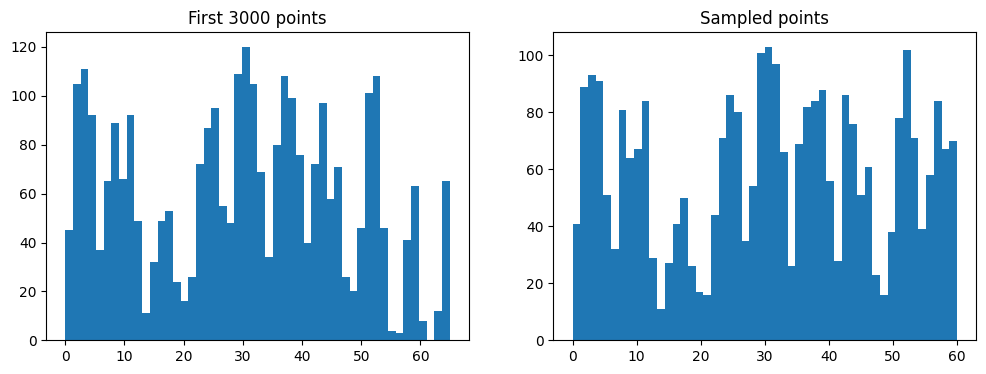

In [41]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(locs_s.iloc[:3000]['T'], bins=50)
plt.title('First 3000 points')
plt.subplot(1, 2, 2)
plt.hist(sampled_locs['T'], bins=50)
plt.title('Sampled points')
plt.show()

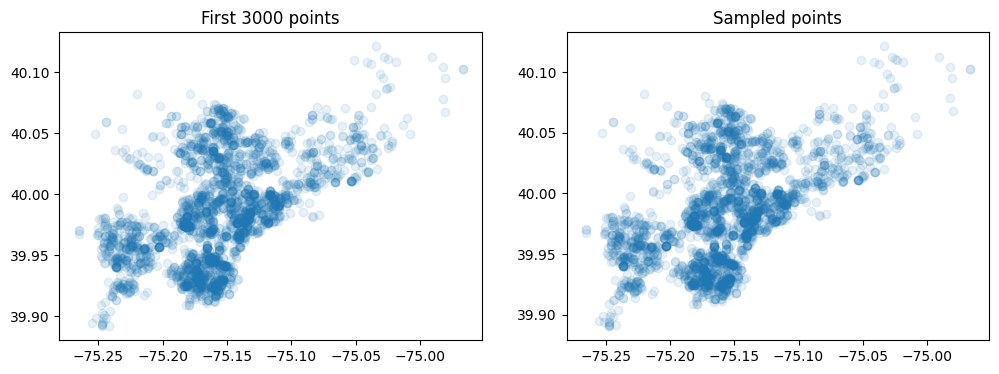

In [42]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(locs_s.iloc[:3000]['X'], locs_s.iloc[:3000]['Y'], alpha=0.1)
plt.title('First 3000 points')
plt.subplot(1, 2, 2)
plt.scatter(sampled_locs['X'], sampled_locs['Y'], alpha=0.1)
plt.title('Sampled points')
plt.show()

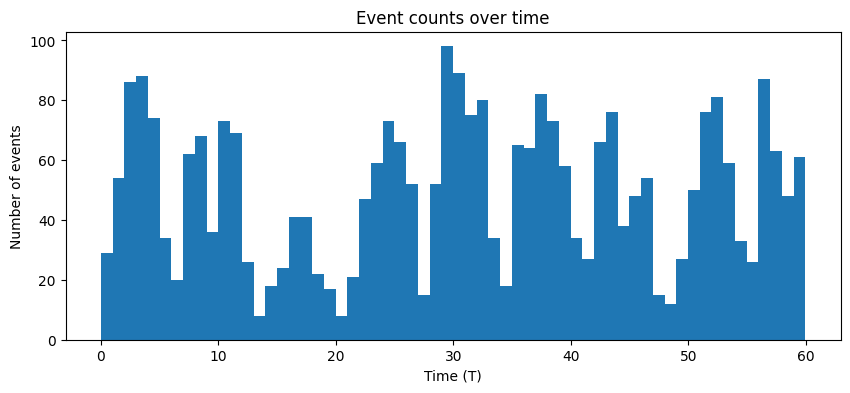

In [28]:
# plot the sample
plt.figure(figsize=(10,4))
plt.hist(sampled_locs['T'], bins=60)  # 60 bins = roughly monthly if T is by day
plt.xlabel('Time (T)')
plt.ylabel('Number of events')
plt.title('Event counts over time')
plt.show()

In [11]:
## Cox-Hawkes model
# a_0 = baseline log-intensity
# alpha = magnitute of excitation
# bate = temporal trigger param
# sigmax_2 = spatial trigger param
model = Hawkes_Model(locs_halfyear,#spatiotemporal points
                     philly,#philly boundaries
                     60,#Time frame 
                     True,#use Cox as background
#                     spatial_cov=data['covariates'],#spatial covariate matrix
#                     cov_names = column_names,#columns to use from covariates
                     a_0=dist.Normal(0,2), 
                     # alpha = dist.Beta(20,60),#set priors
                     alpha = dist.Beta(2,2),
                     # beta=dist.HalfNormal(2.0),
                     beta=dist.HalfNormal(1.0),
                     sigmax_2=dist.HalfNormal(0.25)
                    )

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/bstpp/main.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  args['A_area'] = A.area.sum()/((A_[0,1]-A_[0,0])*(A_[1,1]-A_[1,0]))


In [ ]:
rng_key = jax.random.PRNGKey(999)  # Use any seed number you want

# Run MCMC with unpacked arguments
mcmc_results = model.run_mcmc(
    rng_key,
    num_warmup=1000,    # Number of warmup steps
    num_samples=2000,   # Number of samples to draw after warmup
    num_chains=1,       # Number of parallel chains
    thinning=1          # Take every nth sample
)

# Run MCMC
mcmc_results = model.run_mcmc(rng_key, mcmc_args)

warmup:  31%|███▏      | 941/3000 [1:32:11<54:42:32, 95.65s/it, 1023 steps of size 1.36e-06. acc. prob=0.78]

100%|██████████| 5000/5000 [06:14<00:00, 13.35it/s, init loss: -16205.7070, avg. loss [4751-5000]: -28510.5391]


Sampling Posterior...

SVI elapsed time: 415.343759059906


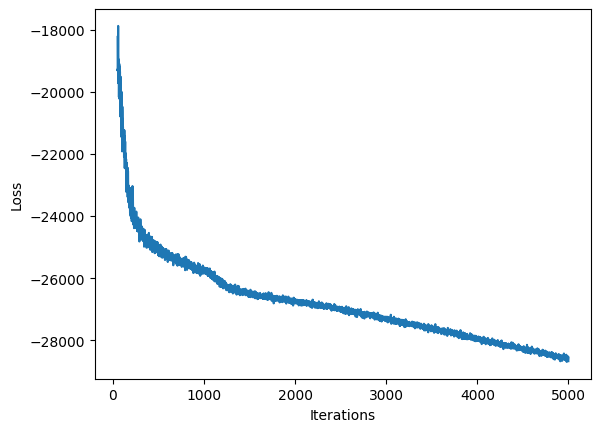

In [37]:
#model.run_svi(lr=0.02,num_steps=15000)
model.run_svi(lr=0.005,num_steps=5000) # less interations and bigger learning rate

In [137]:
model.save_rslts('output/sample_2024_2000/cox_hawkes_output.pkl')

In [154]:
model.load_rslts('output/sample_2024_2000/cox_hawkes_output.pkl')

In [ ]:
model.log_expected_likelihood(sampled_locs)

8542.8310546875

In [57]:
model.expected_AIC()

-62074.125

0.5907642841339111

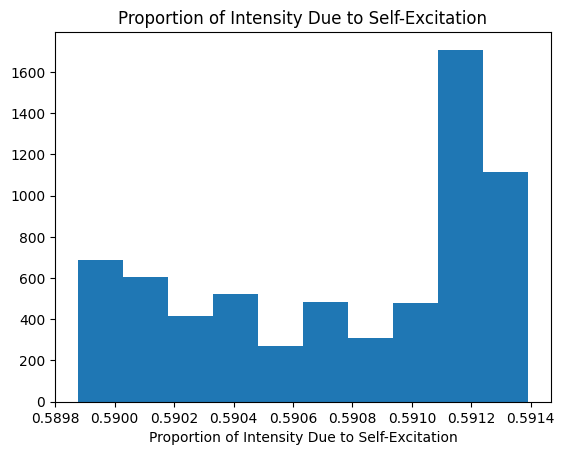

In [58]:
# the proportion of events explained by excitation 
model.plot_prop_excitation()

,Post Mean,Post Std,P(w>0),[0.025,0.975]
alpha,0.714968,0.000051,1.0,0.714868,0.715039
beta,0.339227,0.000006,1.0,0.339220,0.339243
sigmax_2,0.218718,0.000049,1.0,0.218648,0.218808


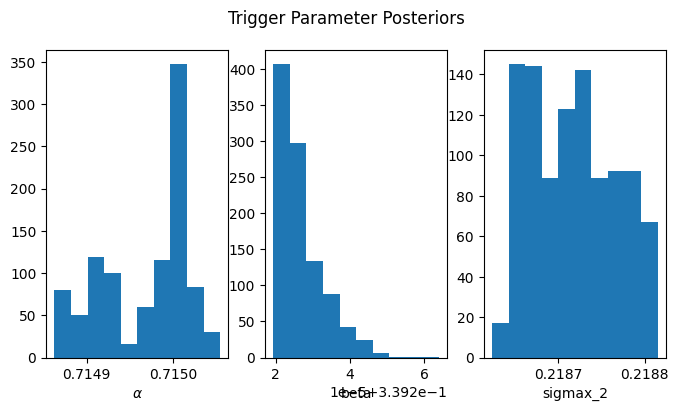

In [59]:
model.plot_trigger_posterior(trace=False)


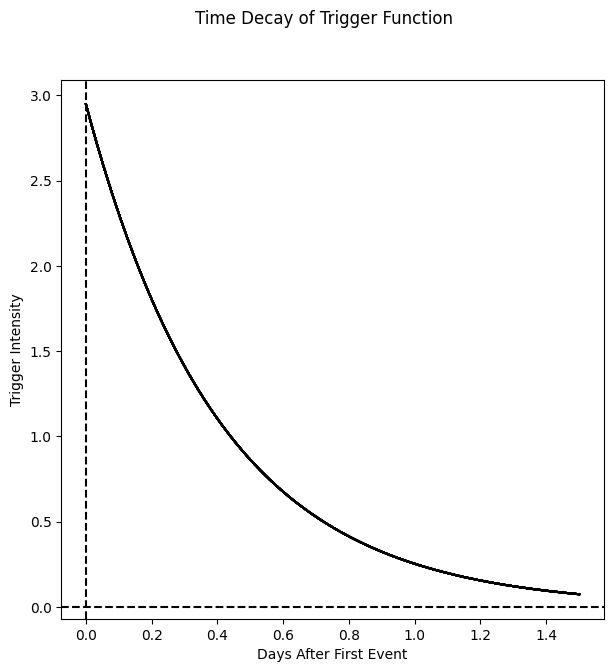

In [60]:
model.plot_trigger_time_decay()


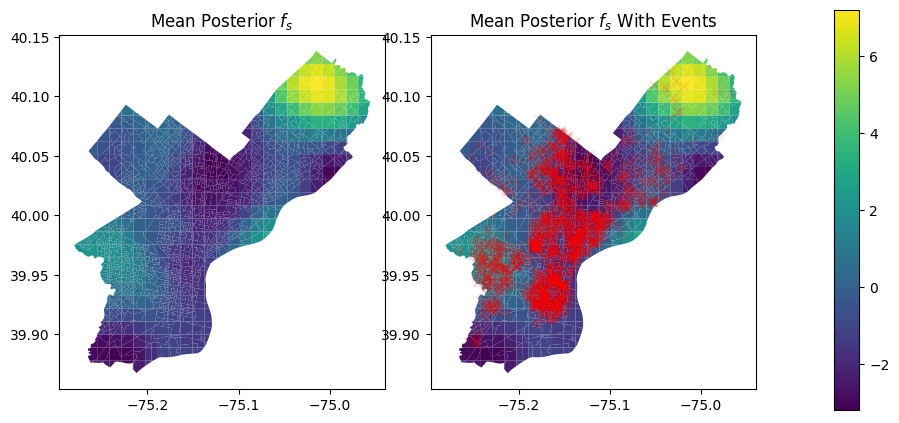

In [61]:
model.plot_spatial(include_cov=False)


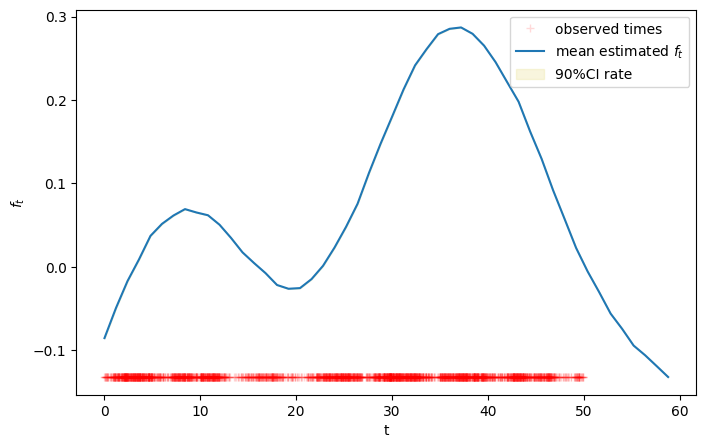

In [62]:
model.plot_temporal()

In [7]:
from bstpp.main import LGCP_Model, Hawkes_Model, load_Chicago_Shootings, load_Boko_Haram

data = load_Chicago_Shootings()


In [8]:
data['covariates'].head()

,UNEMP_DENS,MEDINC,MED_HV,assoc_plus,OPENperc,VACANT_DEN,VAC_HU_pct,HCUND20K_L,POP_DENS,CT_SP_WCHI,geometry
0,0.063963,35796.11650,244769.5035,0.493141,0.103845,271195.053340,0.090746,187.0,4.630433e+07,0.046107,"POLYGON ((-87.60914 41.84469, -87.60915 41.844..."
1,0.104690,36837.60684,334959.3496,0.474896,0.313313,216494.030596,0.069822,21.0,4.094942e+07,0.097232,"POLYGON ((-87.59215 41.81693, -87.59231 41.816..."
2,0.082740,17216.78622,168463.7068,0.192551,0.024613,265482.354506,0.262734,42.0,1.113540e+07,0.049761,"POLYGON ((-87.6288 41.80189, -87.62879 41.8017..."
3,0.069500,39110.73826,238617.0213,0.458755,0.032536,430608.293803,0.109300,131.0,4.848968e+07,0.069035,"POLYGON ((-87.60671 41.81681, -87.6067 41.8165..."
4,0.047852,52336.44860,272848.6647,0.638845,0.184808,66209.952599,0.104290,121.0,6.141842e+07,0.041732,"POLYGON ((-87.59215 41.81693, -87.59215 41.816..."
